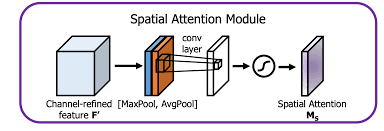

- Different from the channel attention, the spatial attention focuses on 'where' is an informative part

# Spatial_Attention 학습을 위한 코드

- SENet 코드에서 channel_attention을 spatial_attention으로 변경

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size = 3, padding = 1):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding, bias = False)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # 채널을 1로 압축
        max_out, _ = torch.max(x, dim=1, keepdim=True) # 채널을 1로 압축
        x = torch.cat([avg_out,max_out], dim=1)
        x = self.conv1(x)
        x = self.sig(x)
        return x  


class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride =1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        self.spatial_attention = SpatialAttention()
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Spatial Attention
        w = self.spatial_attention(out)
        
        # 텐서 크기 맞추기
        if w.size() != out.size():
            w = F.interpolate(w, size=out.size()[2:], mode='bilinear', align_corners=False)
        out = out * w  

        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def SENet18():
    return SENet(BasicBlock, [2,2,2,2])


def train(net, trainloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{i + 1}, {running_loss / 100:.3f}]')
            running_loss = 0.0

def test(net, testloader, criterion, device):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    print(f'Test Loss: {test_loss / len(testloader):.3f} | Accuracy: {100. * correct / total:.3f}%')

def main():
    # Data preparation
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # SENet18을 이용하여 학습
    net = SENet18().to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    for epoch in range(20):
        print(f'Epoch: {epoch + 1}')
        train(net, trainloader, criterion, optimizer, device)
        test(net, testloader, criterion, device)
        scheduler.step()
    
    # Save the trained model
    torch.save(net.state_dict(), 'senet_spatial_cifar10.pth')

if __name__ == '__main__':
    main()

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1


KeyboardInterrupt: 

#### SENet(Spatial_Attention 사용) 시각화를 위한 코드

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np

class SENetWithFeatures(SENet):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENetWithFeatures, self).__init__(block, num_blocks, num_classes)

    # 각 layer의 feature를 저장
    def forward(self, x):
        input_img = x.detach().cpu().numpy()
        out = F.relu(self.bn1(self.conv1(x)))
        features_layer1 = out.detach().cpu().numpy()
        out = self.layer1(out)
        features_layer2 = out.detach().cpu().numpy()
        out = self.layer2(out)
        features_layer3 = out.detach().cpu().numpy()
        out = self.layer3(out)
        features_layer4 = out.detach().cpu().numpy()
        out = self.layer4(out)
        features_layer5 = out.detach().cpu().numpy()
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out, [features_layer1, features_layer2, features_layer3, features_layer4, features_layer5]

def load_model(model_path, device):
    net = SENetWithFeatures(BasicBlock, [2,2,2,2])
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    return net

def save_feature_maps(feature_maps, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, feature_map in enumerate(feature_maps):
        np.save(os.path.join(output_dir, f'feature_map_layer_{i+1}.npy'), feature_map)

def main():
    # Data preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load the trained model
    model_path = 'senet_spatial_cifar10.pth'
    net = load_model(model_path, device)
    
    # Extract and save feature maps for a sample input
    net.eval()
    sample_inputs, _ = next(iter(testloader))
    sample_inputs = sample_inputs.to(device)
    _, feature_maps = net(sample_inputs)
    
    # Save feature maps
    output_dir = 'feature_maps'
    save_feature_maps(feature_maps, output_dir)
    print(f'Feature maps saved in {output_dir}')

if __name__ == '__main__':
    main()

Files already downloaded and verified
Feature maps saved in feature_maps


#### 저장한 npy 파일 시각화

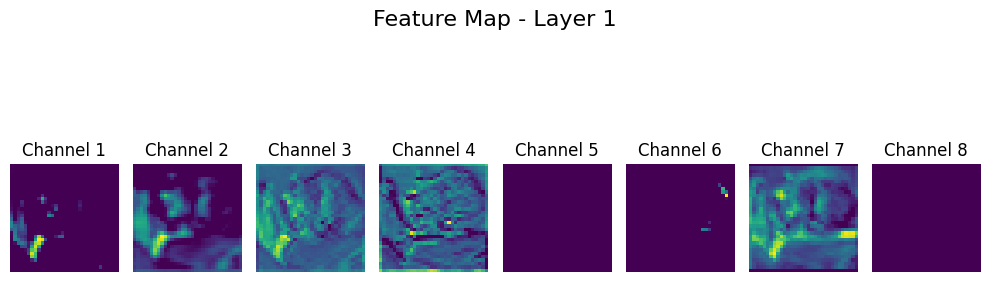

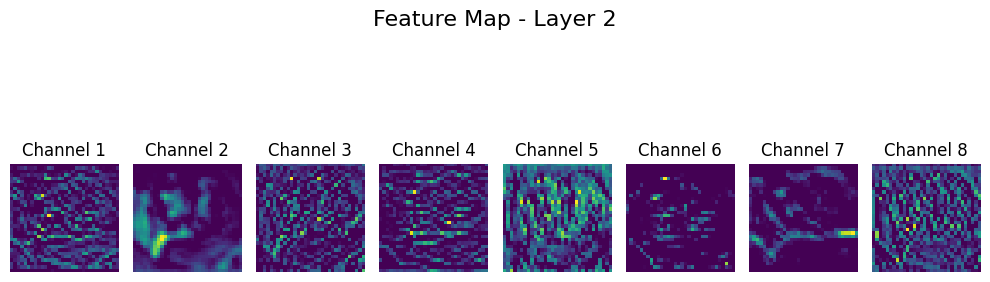

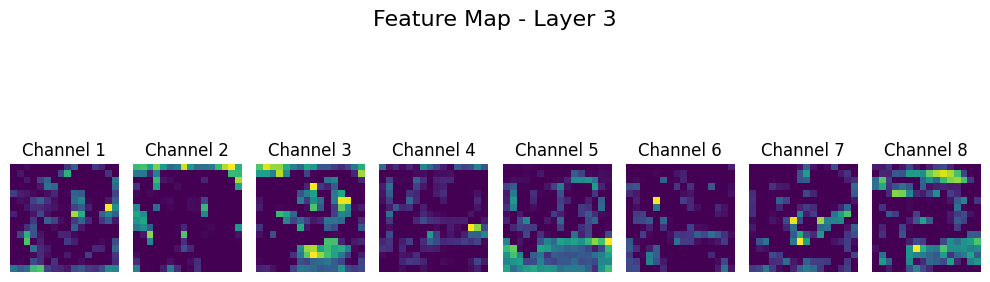

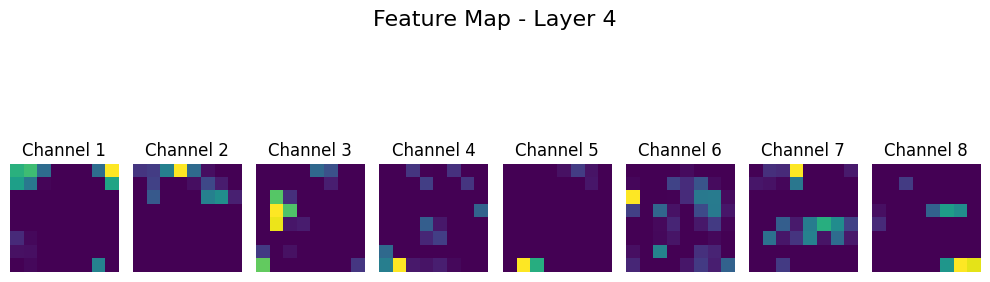

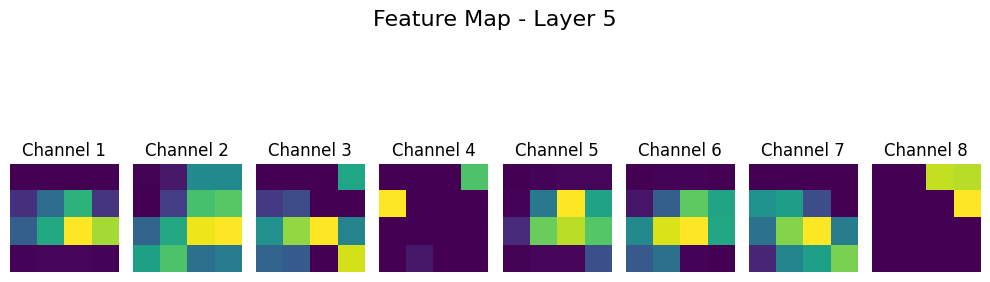

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_feature_map(feature_map, layer_idx, num_channels=8, save_dir='feature_map_visualizations'):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Select the first 'num_channels' channels
    channels = feature_map[0, :num_channels, :, :]
    
    # Create a figure to display the feature maps
    fig, axs = plt.subplots(1, num_channels, figsize=(10, 4))
    
    for i in range(num_channels):
        axs[i].imshow(channels[i], cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'Channel {i+1}')
    
    plt.suptitle(f'Feature Map - Layer {layer_idx + 1}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save the figure
    plt.savefig(os.path.join(save_dir, f'feature_map_layer_{layer_idx + 1}.png'))
    plt.show()

def main():
    output_dir = 'feature_maps'
    save_dir = 'feature_map_visualizations'
    
    # Load and visualize each feature map
    for layer_idx in range(5):  # Assuming there are 5 layers
        feature_map = np.load(os.path.join(output_dir, f'feature_map_layer_{layer_idx + 1}.npy'))
        visualize_feature_map(feature_map, layer_idx, num_channels=8, save_dir=save_dir)

if __name__ == '__main__':
    main()
